# Week 03. Document Distance and Topic Models

Sequencing Legal DNA: NLP for Law and Political Economy<br>
Elliott Ash, ETH Zurich

In [2]:
# set random seed
import numpy as np
np.random.seed(4)

In [55]:
# Setup
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
X = pd.read_pickle('X.pkl').toarray()

# Document Distance

## Cosine Similarity

In [4]:
# compute pair-wise similarities between all documents in corpus"
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(X[:100])
sim.shape

(100, 100)

In [56]:
# TF-IDF Similarity
tsim = cosine_similarity(X[:100])
tsim[:3,:3]

array([[1.        , 0.16771115, 0.41233013],
       [0.16771115, 1.        , 0.25182999],
       [0.41233013, 0.25182999, 1.        ]])

## Jensen-Shannon Divergence

In [6]:
from scipy.stats import entropy
def js(p, q):
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2
js(tsim[0],tsim[1])

0.2977188872937293

# Clustering

## K-means clustering

In [23]:
# create 100 clusters of similar documents
from sklearn.cluster import KMeans
num_clusters = 100
km = KMeans(n_clusters=num_clusters,n_jobs=-1)
km.fit(X)
doc_clusters = km.labels_.tolist()

In [24]:
df['cluster'] = doc_clusters
df[df['cluster']==1]['opinion_text']

63     JUSTICE O'CONNOR delivered the opinion of the ...
511    Justice Kennedy delivered the opinion of the C...
558    Chief Justice Roberts delivered the opinion of...
679    JUSTICE O'CONNOR announced the judgment of the...
Name: opinion_text, dtype: object

In [57]:
#%% Principal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.06008335, 0.03858287, 0.03146098])

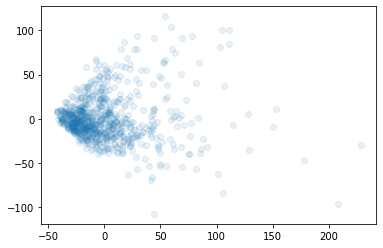

In [39]:
#%% PCA Viz
import matplotlib.pyplot as plt
plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)
plt.show()

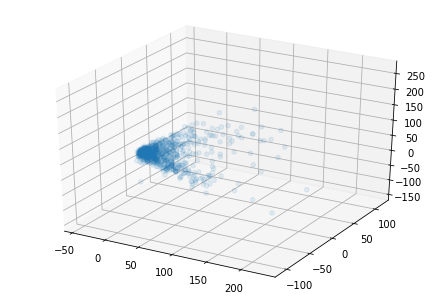

In [40]:
#%% PCA 3D Viz
from mpl_toolkits.mplot3d import Axes3D
Axes3D(plt.figure()).scatter(Xpca[:,0],Xpca[:,1], Xpca[:,2], alpha=.1)
plt.show()

In [58]:
#%% make components to explain 95% of variance
pca = PCA(n_components=.95)
X95 = pca.fit_transform(X)
pca.n_components_

304

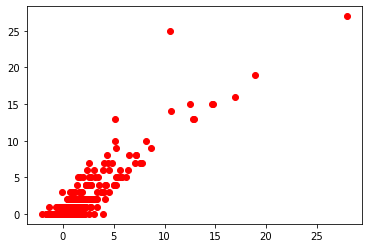

In [59]:
#%% PCA Inverse Transform
Xrestore = pca.inverse_transform(X95)
plt.plot(Xrestore[0],X[0],'ro')

In [60]:
#%% Incremental PCA
X_mm = np.memmap('X.pkl',shape=(32567, 525))

from sklearn.decomposition import IncrementalPCA
inc_pca = IncrementalPCA(n_components=100, batch_size=1000)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=1000, copy=True, n_components=100, whiten=False)

In [61]:
#%% PC Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
Y = df['log_cite_count']
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg,
                         X95[:,:10],
                         Y) 
scores.mean()

0.1927975943615003

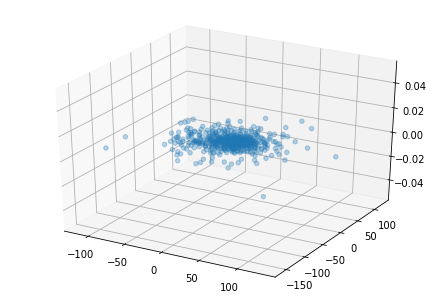

In [62]:
#%% MDS, Isomap, and T-SNE
from sklearn.manifold import MDS, Isomap, TSNE
mds = MDS(n_components=2)
Xmds = mds.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xmds[:,0],Xmds[:,1], alpha=.3)

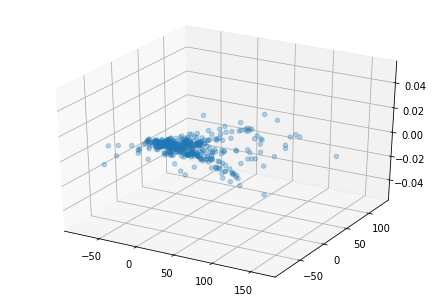

In [63]:
#%% Isomap
iso = Isomap(n_components=2)
Xiso = iso.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xiso[:,0],Xiso[:,1], alpha=.3)

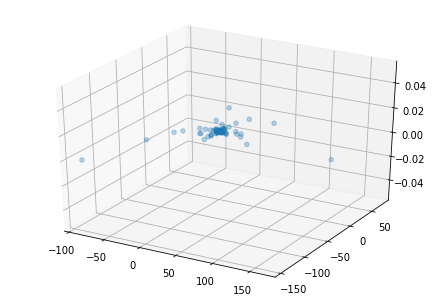

In [64]:
#%% t-SNE
tsne = TSNE(n_components=2, n_iter=250)
Xtsne = tsne.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xtsne[:,0],Xtsne[:,1], alpha=.3)

# Latent Dirichlet Allocation

In [67]:
# clean document
from gensim.utils import simple_preprocess
doc_clean = [simple_preprocess(doc) for doc in df['opinion_text'][:100]]
# TODO: split into paragraphs

# randomize document order
from random import shuffle
shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

[(0,
  [('the', 0.053843066),
   ('of', 0.03402462),
   ('to', 0.028368922),
   ('and', 0.020355806),
   ('in', 0.018844433),
   ('court', 0.014218943),
   ('that', 0.013238575),
   ('at', 0.009571115),
   ('not', 0.00940114),
   ('for', 0.009167905)]),
 (1,
  [('the', 0.078833655),
   ('of', 0.036967933),
   ('to', 0.027360396),
   ('that', 0.022359744),
   ('in', 0.019678056),
   ('and', 0.014604761),
   ('for', 0.013045665),
   ('at', 0.01212036),
   ('is', 0.010303677),
   ('not', 0.0093233455)]),
 (2,
  [('the', 0.07834605),
   ('of', 0.038195793),
   ('to', 0.030065242),
   ('and', 0.020550473),
   ('that', 0.0199945),
   ('in', 0.019355156),
   ('at', 0.012360667),
   ('ed', 0.009622333),
   ('for', 0.009441641),
   ('is', 0.008912873)]),
 (3,
  [('the', 0.057440717),
   ('of', 0.034373485),
   ('in', 0.023089822),
   ('to', 0.023064876),
   ('and', 0.015981985),
   ('that', 0.015030202),
   ('at', 0.014044342),
   ('ed', 0.008872652),
   ('districts', 0.008305437),
   ('is', 0.

In [68]:
# to get the topic proportions for a document, use
# the corresponding row from the document-term matrix.
lda[doc_term_matrix[0]]

[(1, 0.1690294), (2, 0.82849014)]

In [70]:
# or, for all documents
[lda[d] for d in doc_term_matrix]

[[(1, 0.16167526), (2, 0.8364575)],
 [(7, 0.9956197)],
 [(0, 0.99414694)],
 [(1, 0.14497764), (2, 0.17666267), (4, 0.36873645), (7, 0.30515134)],
 [(1, 0.82406265), (2, 0.17562401)],
 [(2, 0.4462131), (4, 0.5533672)],
 [(1, 0.9995068)],
 [(1, 0.9348071), (2, 0.065114)],
 [(2, 0.99447703)],
 [(2, 0.9951017)],
 [(7, 0.9997406)],
 [(1, 0.99867296)],
 [(1, 0.9973224)],
 [(2, 0.9411758), (7, 0.05436844)],
 [(1, 0.9965436)],
 [(1, 0.9531308), (2, 0.046697874)],
 [(0, 0.9527535), (1, 0.047051195)],
 [(2, 0.99674326)],
 [(2, 0.6217821), (7, 0.37086993)],
 [(1, 0.9810284), (2, 0.014616073)],
 [(1, 0.012191162), (2, 0.9841301)],
 [(4, 0.9996724)],
 [(1, 0.99908936)],
 [(7, 0.99980396)],
 [(2, 0.9997606)],
 [(1, 0.025687331), (2, 0.9739116)],
 [(1, 0.80724114), (2, 0.1833064)],
 [(2, 0.9963834)],
 [(1, 0.37679863), (2, 0.022831429), (8, 0.6000634)],
 [(1, 0.0153584955), (2, 0.98448634)],
 [(0, 0.99982333)],
 [(1, 0.9842212), (7, 0.01548564)],
 [(2, 0.27154636), (4, 0.7270182)],
 [(4, 0.41870156),

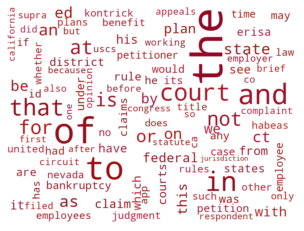

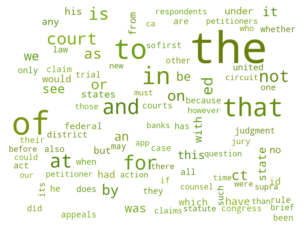

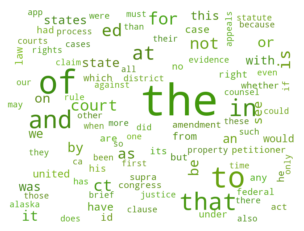

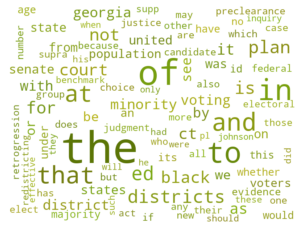

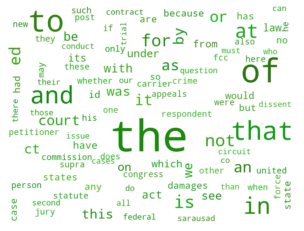

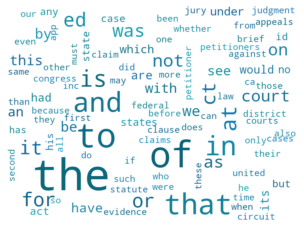

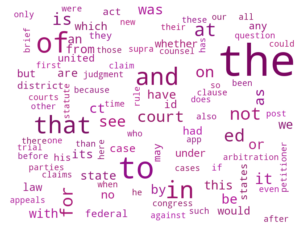

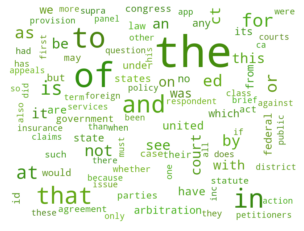

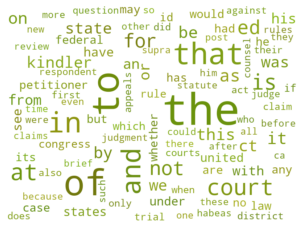

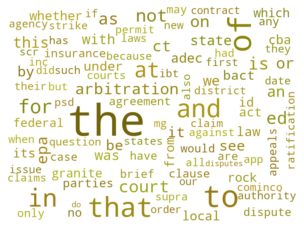

In [71]:
###
# LDA Word Clouds
###

from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# make directory if not exists
from os import mkdir
try:
    mkdir('lda')
except:
    pass

# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=-1,
                                 num_words=100,
                                 formatted=False):
    
    #logweights = [w[0], np.log(w[1]) for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()
